In [1]:
import os
import chess
import chess.engine
import pandas as pd
import numpy as np
from plotting_functions import plot_heat_map, plot_samples
import itertools
import zentables


## Define Functions

In [2]:
# for cp to wp
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cp_to_wp(score_val_cp_white):
    """
    Converts centipawn score val (signed with white pos/black neg) to win prob for white
    
    Args:
        score_val_cp_white: centipawn value (signed with white positive black negative) for position
    Returns:
        win probability: measure between 0 and 1 giving probability of white win
        Note: taken for logistic regression model applied to predict win given centipawn games
    """
    this_const = -0.045821224987387915;
    this_board_score_val = 0.002226678310106879
    #return sigmoid(log_reg_cp.params['const'] + log_reg_cp.params['board_score_val']*score_val_cp_white)
    return sigmoid(this_const + this_board_score_val*score_val_cp_white)

def mate_to_wp(score_val_mate):
    """
    Converts plys from mate to win prob (for the player who is within reach of mate)
    """
    # return sigmoid(log_reg_mate.params['const'] + log_reg_mate.params['score_val_pos']*np.abs(score_val_mate))
    return sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(score_val_mate))


# add support for if mate == 0!!!!!!!
def process_score(this_score, white_active):
    """
    Input:
    this score:  what is returned from stockfish
    white active: is whether it is white's move
    
    Output:
    score_dict: contains
    """
    
    white_score = this_score.white()
    is_mate = white_score.is_mate()
    
    if is_mate:
        score_type = 'mate'
        score_val = white_score.mate() # this is framed as white'
        if score_val > 0:
            wp = mate_to_wp(score_val) # this is framed as whichever side is close to mate
        elif score_val < 0:
            wp = 1 - mate_to_wp(score_val)
        elif score_val == 0:
            wp = 1 if white_active else 0
            # 1 or -1 depending on whose move this is.... so process score needs to take in who is active
    else: # centipawn...
        score_type = 'cp'
        score_val = white_score.score()
        wp = cp_to_wp(score_val)
    
    wp_active = wp if white_active else 1 - wp
        
    #score_dict = {'type': score_type, 'val': score_val, 'wp': wp}
    return wp_active


####  Set up folders to stockfish (chess engine) and data csv file

Download stockfish from: https://stockfishchess.org/download/

In [3]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
chess_data_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Data'
chess_csv_file = 'lichess_db_standard_rated_2019-01.csv'
chess_data_fullfile = os.path.join(chess_data_folder,chess_csv_file)


Read in and filter data

In [4]:
data_raw = pd.read_csv(chess_data_fullfile, nrows=500000)
data_raw.head()

/var/folders/s3/06m5bv8s03v5c2y_thvlc6qr0000gp/T/ipykernel_11970/508358596.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(chess_data_fullfile, nrows=500000)


,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,...,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count
0,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,...,8,2,2,0,20,2,2,8,2,2
1,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,...,8,2,2,0,20,2,2,8,2,2
2,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,...,8,2,2,0,29,2,2,8,2,2
3,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,...,8,2,2,0,29,2,2,8,2,2
4,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,...,8,2,2,0,27,2,2,8,2,2


In [5]:
# what game types do we care about? filter dataframe to only include these time-control settings (these occur on first page) - new name for df is data_filt
game_time_types = ['600+0']

# filter based on if it's in these game settings... 
data_filt = data_raw.loc[data_raw.time_control.isin(game_time_types)].reset_index(drop = True)

def count_pieces(this_fen):
    
    n_pieces = 0
    for i in this_fen:
        if i == ' ':
            break
        
        if i.isalpha():
            n_pieces += 1
    
    return n_pieces

data_filt['n_pieces'] = data_filt.apply(lambda row : count_pieces(row['board']), axis = 1)

data_filt = data_filt.loc[data_filt.n_pieces == 7,:].reset_index(drop=True)


#### Initialize the engine

Use the python-chess package to communicate with the engine.

https://python-chess.readthedocs.io/en/latest/engine.html

In [6]:
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [7]:
data_filt.shape

(693, 48)

## Example Positions

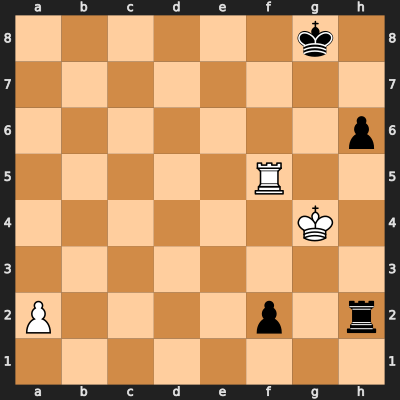

In [8]:
data_idx = 30
this_row = data_filt.loc[data_idx,:]
this_fen = this_row.board
current_board = chess.Board(this_fen)
this_white_active = this_row.white_active
player_to_move = "white" if this_white_active else "black"
chess.svg.board(current_board, size = 400)

#### Get each set of moves which can be removed to define each construal.

In [9]:
full_piece_map = current_board.piece_map()
eligible_keys_for_removal = [key for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
eligible_vals_for_removal = [val.symbol() for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
eligible_squares_for_removal = [eligible_vals_for_removal[i]+chess.square_name(eligible_keys_for_removal[i]) for i in range(len(eligible_keys_for_removal))]

# want to get every combination of keys we might remove
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

key_removal_subsets = []
square_removal_subsets = []
n_pieces = []

n_eligible_pieces_for_removal = len(eligible_squares_for_removal)
for n in range(0,n_eligible_pieces_for_removal+1):
    key_removal_subsets.extend(findsubsets(eligible_keys_for_removal,n))
    these_subsets = findsubsets(eligible_squares_for_removal,n)
    square_removal_subsets.extend(these_subsets)
    #n_pieces.append(1 + n_eligible_pieces_for_removal - len(these_subsets))

In [10]:
print("Eligible sets of pieces for removal: ")
display(square_removal_subsets)

Eligible sets of pieces for removal: 


[(),
 ('ph6',),
 ('Rf5',),
 ('rh2',),
 ('pf2',),
 ('Pa2',),
 ('ph6', 'Rf5'),
 ('ph6', 'rh2'),
 ('ph6', 'pf2'),
 ('ph6', 'Pa2'),
 ('Rf5', 'rh2'),
 ('Rf5', 'pf2'),
 ('Rf5', 'Pa2'),
 ('rh2', 'pf2'),
 ('rh2', 'Pa2'),
 ('pf2', 'Pa2'),
 ('ph6', 'Rf5', 'rh2'),
 ('ph6', 'Rf5', 'pf2'),
 ('ph6', 'Rf5', 'Pa2'),
 ('ph6', 'rh2', 'pf2'),
 ('ph6', 'rh2', 'Pa2'),
 ('ph6', 'pf2', 'Pa2'),
 ('Rf5', 'rh2', 'pf2'),
 ('Rf5', 'rh2', 'Pa2'),
 ('Rf5', 'pf2', 'Pa2'),
 ('rh2', 'pf2', 'Pa2'),
 ('ph6', 'Rf5', 'rh2', 'pf2'),
 ('ph6', 'Rf5', 'rh2', 'Pa2'),
 ('ph6', 'Rf5', 'pf2', 'Pa2'),
 ('ph6', 'rh2', 'pf2', 'Pa2'),
 ('Rf5', 'rh2', 'pf2', 'Pa2'),
 ('ph6', 'Rf5', 'rh2', 'pf2', 'Pa2')]

In [11]:
key_removal_subsets

[(),
 (47,),
 (37,),
 (15,),
 (13,),
 (8,),
 (47, 37),
 (47, 15),
 (47, 13),
 (47, 8),
 (37, 15),
 (37, 13),
 (37, 8),
 (15, 13),
 (15, 8),
 (13, 8),
 (47, 37, 15),
 (47, 37, 13),
 (47, 37, 8),
 (47, 15, 13),
 (47, 15, 8),
 (47, 13, 8),
 (37, 15, 13),
 (37, 15, 8),
 (37, 13, 8),
 (15, 13, 8),
 (47, 37, 15, 13),
 (47, 37, 15, 8),
 (47, 37, 13, 8),
 (47, 15, 13, 8),
 (37, 15, 13, 8),
 (47, 37, 15, 13, 8)]

### Get best move for each construal

In [12]:
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

def is_board_illegal(this_board, white_active):
    
    # check if removing pieces to create the construal placed the non-acting player in check 
    # - if so, this is an illegal board state
    
    check_board = this_board.copy()
    if white_active:
        check_board.turn == chess.BLACK
    else:
        check_board.turn = chess.WHITE
    
    return check_board.is_check()
    

eval_depth = 10

construal_fens = []
construal_n_pieces = []
construal_selected_actions = []
construal_pieces = []

for removed_pieces in key_removal_subsets:
    new_board = current_board.copy()

    # print(removed_pieces)
    
    new_piece_map = full_piece_map.copy()
    
    for piece in removed_pieces:
        del new_piece_map[piece]
    
    # this is the construal
    new_board.set_piece_map(new_piece_map)    
    
    # get the pieces in this construal
    this_construal_pieces = [val.symbol()+chess.square_name(key) for key,val in new_piece_map.items()]
    construal_pieces.append(this_construal_pieces)
    
    #display(new_board)
    construal_fens.append(new_board.fen())
    
    # add 2 for the kings
    construal_n_pieces.append(2 + n_eligible_pieces_for_removal - len(removed_pieces))
    
    # clear hash and get best move
    
    #display(new_board)
    #print(is_board_illegal(new_board, this_white_active))
    if is_board_illegal(new_board, this_white_active):
        new_best_move = "illegal_board"
    else:    
        engine.configure({"Clear Hash": None})
        info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))
        new_best_move = info['pv'][0].uci()

    construal_selected_actions.append(new_best_move)

construal_selected_actions = np.array(construal_selected_actions)


In [13]:
construal_selected_actions

array(['g4g3', 'g4g3', 'g4f5', 'f5f2', 'g4f3', 'g4g3', 'g4g3', 'f5f2',
       'g4f3', 'g4g3', 'g4h5', 'a2a4', 'g4f5', 'a2a4', 'f5f2', 'f5a5',
       'g4f4', 'g4f3', 'g4g3', 'a2a4', 'f5f2', 'f5a5', 'a2a4', 'g4f3',
       'g4f3', 'g4h5', 'a2a4', 'g4f4', 'g4g3', 'g4g5', 'g4f3', 'g4g5'],
      dtype='<U4')

#### Evaluate each action selected in each construal


In [14]:
unique_construal_selected_actions = np.unique(construal_selected_actions)

action_scores_orig_format = {}
action_scores_processed = {}

construal_action_legal = np.zeros(len(construal_selected_actions),dtype=bool)

construal_benefits = np.zeros(len(construal_selected_actions))
for this_move in unique_construal_selected_actions:

    if this_move == "illegal_board":
        legal_action = False
        processed_score = 0
    else:
    
        # for each construal selected action, push it onto the board
        new_board = current_board.copy()

        if new_board.is_legal(chess.Move.from_uci(this_move)):

            legal_action = True

            new_board.push_uci(this_move)

            # don't need to clear the hash?
            engine.configure({"Clear Hash": None})
            info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth-1))
            print(this_move)
            print(info['score'])
            action_scores_orig_format[this_move] = info['score']
            processed_score = process_score(info['score'], this_white_active)
        else:
            legal_action = False
            processed_score = 0
    
    action_scores_processed[this_move] = processed_score
    construal_benefits[construal_selected_actions == this_move] = processed_score
    construal_action_legal[construal_selected_actions == this_move] = legal_action
    
action_loss = construal_benefits - construal_benefits[0]
action_loss[~construal_action_legal] = np.nan

a2a4
PovScore(Cp(+3), BLACK)
f5a5
PovScore(Cp(+1306), BLACK)
f5f2
PovScore(Cp(+974), BLACK)
g4f3
PovScore(Cp(+1639), BLACK)
g4f4
PovScore(Cp(+1500), BLACK)
g4g3
PovScore(Cp(0), BLACK)


In [15]:
this_white_active

True

In [16]:

action_loss = construal_benefits - construal_benefits[0]
if this_white_active:
    action_loss = -1*action_loss

In [17]:
construal_action_legal

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False])

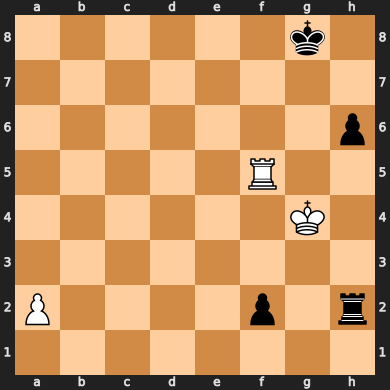

In [18]:
current_board

In [20]:
CP_strings = [' '.join(cp) for cp in construal_pieces]

res_df = pd.DataFrame({'construal': CP_strings, 'num_pieces': construal_n_pieces, 'action': construal_selected_actions, 'legal': construal_action_legal, 'value': construal_benefits, 'loss': action_loss})
res_df.zen.pretty()



,construal,num_pieces,action,legal,value,loss
0,kg8 ph6 Rf5 Kg4 rh2 pf2 Pa2,7,g4g3,True,0.488547,-0.000000
1,kg8 Rf5 Kg4 rh2 pf2 Pa2,6,g4g3,True,0.488547,-0.000000
2,kg8 ph6 Kg4 rh2 pf2 Pa2,6,g4f5,False,0.000000,0.488547
3,kg8 ph6 Rf5 Kg4 pf2 Pa2,6,f5f2,True,0.098447,0.390100
4,kg8 ph6 Rf5 Kg4 rh2 Pa2,6,g4f3,True,0.024237,0.464310
5,kg8 ph6 Rf5 Kg4 rh2 pf2,6,g4g3,True,0.488547,-0.000000
6,kg8 Kg4 rh2 pf2 Pa2,5,g4g3,True,0.488547,-0.000000
7,kg8 Rf5 Kg4 pf2 Pa2,5,f5f2,True,0.098447,0.390100
8,kg8 Rf5 Kg4 rh2 Pa2,5,g4f3,True,0.024237,0.464310
9,kg8 Rf5 Kg4 rh2 pf2,5,g4g3,True,0.488547,-0.000000


In [21]:
res_df

,construal,num_pieces,action,legal,value,loss
0,kg8 ph6 Rf5 Kg4 rh2 pf2 Pa2,7,g4g3,True,0.488547,-0.000000
1,kg8 Rf5 Kg4 rh2 pf2 Pa2,6,g4g3,True,0.488547,-0.000000
2,kg8 ph6 Kg4 rh2 pf2 Pa2,6,g4f5,False,0.000000,0.488547
3,kg8 ph6 Rf5 Kg4 pf2 Pa2,6,f5f2,True,0.098447,0.390100
4,kg8 ph6 Rf5 Kg4 rh2 Pa2,6,g4f3,True,0.024237,0.464310
5,kg8 ph6 Rf5 Kg4 rh2 pf2,6,g4g3,True,0.488547,-0.000000
6,kg8 Kg4 rh2 pf2 Pa2,5,g4g3,True,0.488547,-0.000000
7,kg8 Rf5 Kg4 pf2 Pa2,5,f5f2,True,0.098447,0.390100
8,kg8 Rf5 Kg4 rh2 Pa2,5,g4f3,True,0.024237,0.464310
9,kg8 Rf5 Kg4 rh2 pf2,5,g4g3,True,0.488547,-0.000000
